In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
import warnings

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipyleaflet import *

In [7]:
method       = 'hourly'
dataPath     = "/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec/"+method+"/2018 - Jun2Aug/"
metaDataName = "stations_inventory.csv"

# Environment Canada Weather Information

## Province of Quebec Information

In this section, it's computed relevant information about the hourly data from the Province of Quebec. In order to begin our analysis, let us focus our attention on a short space of time. Therefore, we are going to be interested in the period between June 1st and August 31st. Here, we are just concern about Air Temperature. So, most treatments done here are concern about it as well.

In [8]:
#It opens the metadata and selects the Ids of the Province of Quebec with hourly data at least untill 2018.
metaData = pd.read_csv(metaDataName)
quebecStations = metaData[(metaData["Province"] == "QUEBEC") & (metaData["HLY Last Year"] >= 2018)]
IDs = quebecStations["Station ID"].unique()

In [9]:
dataSet = dict()

#It opens them
for ID in IDs:
    data = pd.read_csv(dataPath+str(ID)+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[str(ID)] = data

### Missing Data

Missing data is one of the most relevant information we must know about the data. As it was mentioned above, we are concern about Air Temperature, Relative Humidity, and Dew Point Temperature. So, here it's computed how many stations don't have these measurements in the period of interest.

In [10]:
#It computes how many relevant data are missing on the dataset
countTemp = countRH = countDP   = 0
missingData = pd.DataFrame([], columns = ['Station ID', 'Station Name', 'Has Temp', 'lat', 'lng'])
missingData['Station ID']   = (quebecStations['Station ID'].values).astype('str')
missingData['Station Name'] = quebecStations['Name'].values
missingData['lat']          = np.asarray(quebecStations['Latitude (Decimal Degrees)'].values)
missingData['lng']          = np.asarray(quebecStations['Longitude (Decimal Degrees)'].values)
for key in dataSet:
    data = dataSet[key]
    
    noTmp = data['Temp (°C)'].isna().all()
    countTemp += int(noTmp)
    missingData.loc[missingData['Station ID'] == key,'Has Temp'] = not noTmp

### All Stations Available in 2018

In [11]:
from IPython.display import display, HTML
display(HTML(missingData.to_html()))

,Station ID,Station Name,Has Temp,lat,lng
0,27803,BEAUPORT,False,46.84,-71.20
1,27325,DESCHAMBAULT,True,46.69,-71.97
2,8989,ILE D'ORLEANS,False,47.00,-70.81
3,5237,L'ASSOMPTION,True,45.81,-73.43
4,10871,L'ETAPE,True,47.56,-71.23
5,51457,QUEBEC INTL A,True,46.79,-71.39
6,27646,SHAWINIGAN,True,46.56,-72.73
7,51698,TROIS RIVIERES A,True,46.35,-72.68
8,10764,TROIS-RIVIERES,True,46.35,-72.52
9,8321,TROIS-RIVIERES,True,46.37,-72.68


In [12]:
def countData(dataFrame, dictionary, column, dataQuantity, measName=''):
    '''
    Description: It calculate the pecentage of data available  
    '''
    dataSet = dictionary.copy()
    newdf = dataFrame.copy()
    pct = list()
    for station in dataSet:
        data = dataSet[station]
        pct.append(round(100*data[column].count()/dataQuantity,2))
        
    newdf[measName+" Available Data"+' (%)'] = pct
    return newdf

In [13]:
def fltrbyDQ(dictionary, column, dataQuantity, threshold = 0.6):
    '''
    Description: Filter by Data Quantity. It returns a list with keys that don't have enough data according to the threshold passed.
    '''
    dataSet = dictionary.copy()
    statList = list()
    for station in dataSet:
        data = dataSet[station]
        if data[column].count()/dataQuantity < threshold:
            statList.append(station)
    return statList

In [14]:
def removeItems(dictionary, keys):
    '''
    Description: Remove a list of keys from a dict object.
    '''
    d = dictionary.copy()
    for key in keys:
        d.pop(key)
    return d

In [15]:
dataLength = len(dataSet)
print('Missing Data in %d stations:' %dataLength)
print('Air Temperature:     %.2f'  %(100*countTemp/dataLength) + '%')

Missing Data in 159 stations:
Air Temperature:     11.32%


### Stations that have hourly data from 06/01/2018 to 31/08/2018

In [16]:
availableStations = missingData[(missingData['Has Temp'] == True)]
availableStations.sort_index(axis='index')
availableStations = availableStations.reset_index(drop=True)
availableStations = availableStations[['Station ID', 'Station Name', 'lat', 'lng']]

In [17]:
# clean up dataSet, remainning just the stations that  
avs    = availableStations['Station ID'].values
nodata = np.setdiff1d(missingData['Station ID'].values, avs)
dataSet = removeItems(dataSet, nodata)

In [18]:
from datetime import date

delta = date(2018, 8, 31) - date(2018, 6, 1)
removeList = fltrbyDQ(dataSet, 'Temp (°C)', (delta.days + 1)*24, threshold=0.9)
t90 = removeItems(dataSet,removeList)

In [19]:
availableStations = countData(availableStations, dataSet, 'Temp (°C)', (delta.days + 1)*24, 'Air Temp')
display(HTML(availableStations.to_html()))

,Station ID,Station Name,lat,lng,Air Temp Available Data (%)
0,27325,DESCHAMBAULT,46.69,-71.97,99.95
1,5237,L'ASSOMPTION,45.81,-73.43,100.00
2,10871,L'ETAPE,47.56,-71.23,96.65
3,51457,QUEBEC INTL A,46.79,-71.39,99.91
4,27646,SHAWINIGAN,46.56,-72.73,99.95
5,51698,TROIS RIVIERES A,46.35,-72.68,92.75
6,10764,TROIS-RIVIERES,46.35,-72.52,99.91
7,8321,TROIS-RIVIERES,46.37,-72.68,99.64
8,29452,VALCARTIER A,46.90,-71.50,98.51
9,5293,VALCARTIER A,46.90,-71.50,28.99


In [20]:
print("%.2f" %(100*len(t90)/len(dataSet))+"%", end = ' ') 
print("of the Stations that provide hourly information has at least 90% of the Temperature information")

83.69% of the Stations that provide hourly information has at least 90% of the Temperature information


### Stations Map

In [21]:
from ipywidgets import HTML

m = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
markers = list()
for index, row in availableStations.iterrows():
    location = (row['lat'],row['lng'])
    marker = Marker(location=location, draggable = False)
    msg = HTML()
    msg.value = 'Station: %s; ID: %s; Available Data of Temp: %.2f' %(row['Station Name'],
                                                                    row['Station ID'],
                                                                    row['Air Temp Available Data (%)']) + '%; '
    
    marker.popup = msg
    markers.append(marker)
    
marker_cluster = MarkerCluster(markers=markers)
m.add_layer(marker_cluster)

In [22]:
# mouse interaction handling

from ipywidgets import Label

label = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

**Here, we have a map with all stations available.**

In [23]:
m.on_interaction(handle_interaction)
display(m)
display(label)

Map(center=[53.402689, -70.42401], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Label(value='')

In [24]:
from ipywidgets import HTML

stations90 = availableStations[(availableStations['Air Temp Available Data (%)'] >= 90)]

m2 = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
markers = list()
for index, row in stations90.iterrows():
    location = (row['lat'],row['lng'])
    marker = Marker(location=location, draggable = False)
    msg = HTML()
    msg.value = 'Station: %s; ID: %s; Data Available of Temp: %.2f' %(row['Station Name'],
                                                                    row['Station ID'],
                                                                    row['Air Temp Available Data (%)']) + '%; '
    marker.popup = msg
    markers.append(marker)
    
marker_cluster = MarkerCluster(markers=markers)
m2.add_layer(marker_cluster)

In [25]:
# mouse interaction handling

from ipywidgets import Label

label2 = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label2.value = str(kwargs.get('coordinates'))

**Here, we have a map with all stations available that have at least 90% of the hourly data.**

In [26]:
m2.on_interaction(handle_interaction)
display(m2)
display(label2)

Map(center=[53.402689, -70.42401], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Label(value='')

### Temperature Histogram and Boxplot

In [27]:
tmp = np.asarray([dataSet[key]['Temp (°C)'].values for key in dataSet]).flatten()
tmp = tmp[~np.isnan(tmp)]

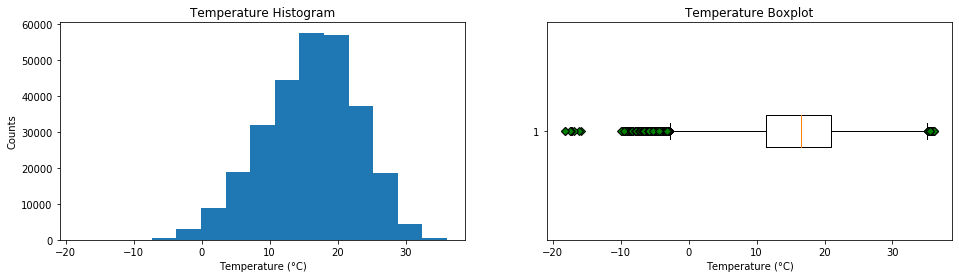

In [28]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, ax = plt.subplots(1, 2, figsize =(16,4))

ax[0].set_title('Temperature Histogram')
ax[0].hist(tmp, bins=15)
ax[0].set(xlabel='Temperature (°C)', ylabel='Counts')

ax[1].set_title('Temperature Boxplot')
ax[1].boxplot(tmp, vert = False, flierprops=green_diamond)
_ = ax[1].set(xlabel='Temperature (°C)')

### Relative Humidity Histogram and Boxplot

In [29]:
rh = np.asarray([dataSet[key]['Rel Hum (%)'].values for key in dataSet]).flatten()
rh = rh[~np.isnan(rh)]

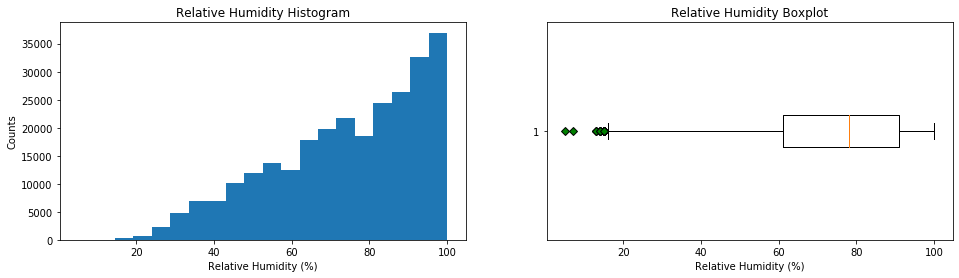

In [30]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, ax = plt.subplots(1, 2, figsize =(16,4))

ax[0].set_title('Relative Humidity Histogram')
ax[0].hist(rh, bins=20)
ax[0].set(xlabel='Relative Humidity (%)', ylabel='Counts')

ax[1].set_title('Relative Humidity Boxplot')
ax[1].boxplot(rh, vert = False, flierprops=green_diamond)
_ = ax[1].set(xlabel='Relative Humidity (%)')

### Stations Clusters

In order to have an alternative method to do analysis, we can group the stations clustering them calculating their mean values. Here we are going to do an approach using Kmean algorithm to cluster the stations. Doing it, we obtain stations labeled as following.

In [31]:
from sklearn.cluster import KMeans
import numpy as np

X = stations90[['lat', 'lng']].values
kmeans = KMeans(n_clusters=9, random_state=42, n_init=1000, n_jobs = 4, max_iter=1000, precompute_distances=True).fit(X)

In [32]:
import warnings

warnings.filterwarnings(action='ignore')
stations90['Cluster Label'] = kmeans.labels_
warnings.filterwarnings(action='default')

stations90 = stations90[['Station ID', 'Station Name', 'lat','lng','Cluster Label']]
stations90.index = range(stations90.shape[0])
stations90.rename(columns={'lat':'Latitude', 'lng':'Longitude'}, inplace=True)

display(HTML(stations90.to_html()))

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></…

In [33]:
from ipywidgets import HTML

colors = ['red', 'black', 'blue', 'yellow', 'green', 'purple', 'gray', 'orange', 'magenta']
coor = stations90[['Latitude','Longitude']].values
name = stations90['Station Name'].values
label = stations90['Cluster Label'].values


m3 = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
for i in range(len(label)):
    circle_marker = CircleMarker()
    circle_marker.location = (coor[i][0],coor[i][1])
    circle_marker.radius = 10
    circle_marker.color = colors[label[i]]
    circle_marker.fill_color = colors[label[i]]

    
    marker = Marker(location=(coor[i][0],coor[i][1]), draggable = False)
    msg = HTML()
    msg.value = 'Station: %s; Cluster: %d' %(name[i], label[i])
    marker.popup = msg
    m3.add_layer(marker)
    m3.add_layer(circle_marker)

In [34]:
# mouse interaction handling

from ipywidgets import Label

label3 = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label3.value = str(kwargs.get('coordinates'))

In [35]:
m3.on_interaction(handle_interaction)
display(m3)
display(label3)

Map(center=[53.402689, -70.42401], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Label(value='')

In [36]:
from datetime import date

delta = date(2018, 8, 31) - date(2018, 6, 1)
removeList = fltrbyDQ(dataSet, 'Temp (°C)', (delta.days + 1)*24, threshold=0.9)
dataSet90 = removeItems(dataSet,removeList)

for key in dataSet90:
    dataSet90[key]['Temp (°C)'] = dataSet90[key]['Temp (°C)'].interpolate(method='nearest', fill_value='extrapolate')
    dataSet90[key] = dataSet90[key][['Date/Time','Station Name','Temp (°C)','Latitude (y)','Longitude (x)']]

In [37]:
clustersSet = dict()

for label in stations90['Cluster Label'].unique():
    s = stations90[stations90['Cluster Label'] == label]
    stations = s['Station ID'].values.astype('str')
    
    dataList = list()
    for ID in stations:
        dataList.append(dataSet90[ID].copy())
    
    total = len(dataList)
    for i in range(1,len(dataList)):
        dataList[0]['Temp (°C)'] = dataList[0]['Temp (°C)'].add(dataList[i]['Temp (°C)'])
    dataList[0]['Temp (°C)'] = dataList[0]['Temp (°C)']/total
        
    clustersSet[str(label)] = dataList[0]

# Stations of Interest

Our goal here is to compute heatwaves using <a href="https://doi.org/10.1002/joc.5294">Geirinhas</a> algorithm. To do so, we have to choose some regions to do the analysis. It was chosen 22 regions, but we have to guarantee that these regions have proper information. Bellow, we have a raw analysis of missing data in these regions.

## Daily Data

In [38]:
method       = 'daily'
dataPath     = "/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec/"+method+"/2018 - Jun2Aug/"

#It opens the metadata and selects the Ids from the Province of Quebec.
metaData = pd.read_csv("stations_inventory.csv")
quebecStations = metaData[(metaData["Province"] == "QUEBEC") & (metaData["DLY Last Year"] >= 2018)]

f = open('WEATHER_STATIONS.txt', 'r')
s = f.readlines()
f.close()
s = [l.replace('\n','') for l in s]

hw_stations = quebecStations[quebecStations['Name'].isin(s)]
IDs = hw_stations['Station ID'].unique()

dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

from datetime import date

delta = date(2018, 8, 31) - date(2018, 6, 1)

In [39]:
dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

#It opens them
for file in stationFiles:
    data = pd.read_csv(dataPath+file+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[file] = data

In [40]:
hw_stations = countData(hw_stations, dataSet, 'Max Temp (°C)', (delta.days + 1), 'Max Temp')
hw_stations = countData(hw_stations, dataSet, 'Min Temp (°C)', (delta.days + 1), 'Min Temp')
hw_stations = hw_stations[['Name', 'Station ID', 'Latitude (Decimal Degrees)',
                           'Longitude (Decimal Degrees)', 'Max Temp Available Data (%)', 'Min Temp Available Data (%)']]
hw_stations.index = range(1,hw_stations.shape[0]+1)
hw_stations

,Name,Station ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Max Temp Available Data (%),Min Temp Available Data (%)
1,BEAUPORT,27803,46.84,-71.20,0.00,0.00
2,L'ASSOMPTION,5237,45.81,-73.43,100.00,100.00
3,SHAWINIGAN,27646,46.56,-72.73,98.91,98.91
4,VALCARTIER A,29452,46.90,-71.50,95.65,96.74
5,GRANBY,5369,45.38,-72.72,100.00,100.00
6,GRANBY,42013,45.37,-72.77,95.65,95.65
7,LENNOXVILLE,5397,45.37,-71.82,98.91,98.91
8,MCTAVISH,10761,45.50,-73.58,96.74,97.83
9,MONTREAL INTL A,51157,45.47,-73.74,100.00,100.00
10,MONTREAL/ST-HUBERT,48374,45.52,-73.42,86.96,86.96


## Hourly Data

In [41]:
method       = 'hourly'
dataPath     = "/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec/"+method+"/2018 - Jun2Aug/"

#It opens the metadata and selects the Ids from the Province of Quebec.
metaData = pd.read_csv("stations_inventory.csv")
quebecStations = metaData[(metaData["Province"] == "QUEBEC") & (metaData["HLY Last Year"] >= 2018)]

f = open('WEATHER_STATIONS.txt', 'r')
s = f.readlines()
f.close()
s = [l.replace('\n','') for l in s]

hw_stations = quebecStations[quebecStations['Name'].isin(s)]
IDs = hw_stations['Station ID'].unique()

dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

from datetime import date

delta = date(2018, 8, 31) - date(2018, 6, 1)

In [42]:
dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

#It opens them
for file in stationFiles:
    data = pd.read_csv(dataPath+file+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[file] = data

In [43]:
hw_stations = countData(hw_stations, dataSet, 'Temp (°C)', (delta.days + 1)*24, 'Temp')
hw_stations = hw_stations[['Name', 'Station ID', 'Latitude (Decimal Degrees)',
                           'Longitude (Decimal Degrees)', 'Temp Available Data (%)']]
hw_stations.index = range(1,hw_stations.shape[0]+1)
hw_stations

,Name,Station ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Temp Available Data (%)
1,BEAUPORT,27803,46.84,-71.20,0.00
2,L'ASSOMPTION,5237,45.81,-73.43,100.00
3,SHAWINIGAN,27646,46.56,-72.73,99.95
4,VALCARTIER A,29452,46.90,-71.50,98.51
5,VALCARTIER A,5293,46.90,-71.50,28.99
6,GRANBY,42013,45.37,-72.77,99.32
7,LENNOXVILLE,5397,45.37,-71.82,99.59
8,MCTAVISH,10761,45.50,-73.58,99.68
9,MONTREAL INTL A,51157,45.47,-73.74,99.91
10,MONTREAL/ST-HUBERT,48374,45.52,-73.42,99.91


Observing our available data, we can conclude that the only region we can not obtain good information is BEAUPORT. In order to overpass this complication, we chose to extract the information that we need from a station next to BEAUPORT. The closest station to BEAUPORT with good information in the period of interest is STE-FOY (U. LAVAL) (ID: 27377). So, filtering the worst stations that are in the same place and replacing BEAUPORT by STE-FOY (U. LAVAL) we obtain the following stations.

In [44]:
s[0] = 'STE-FOY (U. LAVAL)'
hw_stations = quebecStations[quebecStations['Name'].isin(s)]
IDs = hw_stations['Station ID'].unique()

dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

In [45]:
dataSet = dict()

#It gets the name of each file downloaded previously
stationFiles = hw_stations['Station ID'].unique().astype('str')

#It opens them
for file in stationFiles:
    data = pd.read_csv(dataPath+file+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[file] = data

In [46]:
hw_stations = countData(hw_stations, dataSet, 'Temp (°C)', (delta.days + 1)*24, 'Temp')
hw_stations = hw_stations[['Name', 'Station ID', 'Latitude (Decimal Degrees)',
                           'Longitude (Decimal Degrees)', 'Temp Available Data (%)']]
hw_stations.index = range(1,hw_stations.shape[0]+1)
hr_stations = hw_stations[hw_stations['Temp Available Data (%)'] >= 80]
hr_stations.index = range(1,hr_stations.shape[0]+1)
hr_stations

,Name,Station ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Temp Available Data (%)
1,L'ASSOMPTION,5237,45.81,-73.43,100.00
2,SHAWINIGAN,27646,46.56,-72.73,99.95
3,VALCARTIER A,29452,46.90,-71.50,98.51
4,STE-FOY (U. LAVAL),27377,46.78,-71.29,99.86
5,GRANBY,42013,45.37,-72.77,99.32
6,LENNOXVILLE,5397,45.37,-71.82,99.59
7,MCTAVISH,10761,45.50,-73.58,99.68
8,MONTREAL INTL A,51157,45.47,-73.74,99.91
9,MONTREAL/ST-HUBERT,48374,45.52,-73.42,99.91
10,SAINT-GERMAIN-DE-GRANTHAM,47587,45.83,-72.54,91.12


In [47]:
from ipywidgets import HTML

mask1 = ((hr_stations['Station ID'].values == 53002).astype(int) + (hr_stations['Station ID'].values == 26778).astype(int)).astype(bool)
data = hr_stations.drop(index=np.where(mask1== True)[0]+1)

colors = ['red', 'blue']
coor = data[['Latitude (Decimal Degrees)','Longitude (Decimal Degrees)']].values
name = data['Name'].values

m4 = Map(center=(53.402689, -70.424010), scroll_wheel_zoom = True,  zoom=4, basemap=basemaps.Esri.WorldStreetMap)
for i in range(len(coor)):
    circle_marker = CircleMarker()
    circle_marker.location = (coor[i][0],coor[i][1])
    circle_marker.radius = 10
    circle_marker.color = colors[0]
    circle_marker.fill_color = colors[0]

    
    marker = Marker(location=(coor[i][0],coor[i][1]), draggable = False)
    msg = HTML()
    msg.value = 'Station of Interest: %s' %(name[i])
    marker.popup = msg
    m4.add_layer(marker)
    m4.add_layer(circle_marker)

In [48]:
# mouse interaction handling

from ipywidgets import Label

label4 = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label4.value = str(kwargs.get('coordinates'))

In [49]:
# get Julian Day
def getJulianDay(dt, dateCol, yearCol, monthCol, dayCol):
    import datetime as dttm
    
    julianDayCol = "days"
    
    data = dt.copy()
    
    #split datetime into date and time columns
    datetime = np.asarray([d.split(' ') for d in data[dateCol]], dtype='str')
    data[dateCol] = datetime[:,0]
    
    # get year month and day from Date
    date = np.asarray([d.split('-') for d in data[dateCol].values], dtype='uint16')
    
    # create new coluns
    data[yearCol]  = date[:,0]
    data[monthCol] = date[:,1]
    data[dayCol]   = date[:,2]
    data[julianDayCol] = 0
    
    for date in data[dateCol].unique():
        d = dttm.datetime.strptime(date, "%Y-%m-%d") # get datetime object
        data.loc[ (data[yearCol] == d.year) & (data[monthCol] == d.month) & (data[dayCol] == d.day), julianDayCol] = dttm.date(d.year,d.month,d.day).toordinal()
    
    data[julianDayCol] += 1 - data[julianDayCol].min()
    return data

def getMaxMin(dt, column, daysCol):
    '''
    Description:
        It computes max and min value of the specified column passed for each day. 
        It returns a list with the values for each day.
    Input:
        column: The name of the column of interest.
    Output:
        A list with lists containing max and min value for each day. 
        As the following example:

        returning list := [[max1,min1], [max2,min2], ...,[maxN,minN]]
    '''
    julianDayCol = daysCol 
    data = dt.copy()
    
    data = data.dropna(subset=[column])
    
    mxmn_list = list()
    for day in data[julianDayCol].unique():
        d = data[data[julianDayCol] == day] 
        mxmn_list.append([round(np.max(d[column]),2), round(np.min(d[column]),2)])
    
    cols = [julianDayCol, 'Max ' + column, 'Min ' +  column]

    days = np.asarray(data[julianDayCol].unique()).reshape((-1,1))
    mxmn = np.asarray(mxmn_list)
    
    values = np.concatenate((days, mxmn), axis=1)
    newdf = pd.DataFrame(values, columns = cols)
    newdf['DATE'] = data['Date/Time'].unique()
    newdf['days'] = newdf['days'].astype('uint8')
    return newdf

## 1981-2010 Climate Normal

In [50]:
dataSet = dict()

cs = pd.read_csv('closest_stations_81-2010.csv')
IDs = cs['Station ID'].values
dataPath = "/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec/hourly/stationOfInterest/"

#It opens them
for ID in IDs:
    data = pd.read_csv(dataPath+str(ID)+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[str(ID)] = data

In [51]:
hrDataSet = dict()

for station in dataSet:
    data = dataSet[station]

    data = getJulianDay(data, 'Date/Time', 'Year', 'Month', 'Day')
    newdf = getMaxMin(data, 'Temp (°C)', 'days')
    hrDataSet[station] = newdf

<a href="https://doi.org/10.1002/joc.5294">Geirinhas</a> algorithm compares the weather information with a climate normal to compute heatwaves. Therefore, we need to find some period in the past that has at least 30 years of data available in the regions selected previously. Choosing the most recent climate normal, i.e, between 1981 and 2010, we have the following stations in the next 2 tables. These stations were obtained selecting the closest stations to the stations chosen previously and excluding the stations that don't have enough data to do the analysis.

Observing that some of the stations previuouly selected don't have enough information from the past, they had to be replaced by others as well.

In [52]:
dist_rel = pd.read_csv('closest_stations_81-2010.csv')
dist_rel

,Unnamed: 0,Station ID,Closest Station ID,Distance (Km)
0,0,5237,5237,0.00
1,1,27646,5225,15.77
2,2,29452,5254,26.62
3,3,27377,5393,15.15
4,4,42013,5369,4.07
5,5,5397,5397,0.00
6,6,10761,5415,13.68
7,7,51157,5415,0.78
8,8,48374,5447,19.14
9,9,47587,5348,7.25


As we can see above, the stations with IDs equal to 5779 and 5929 are too far from the station of interest. Seeing that nothing can be done to overcome this complication, we are going to have to exclude them from the analysis. These stations belong to the regions of Lac Benoit and Îles de la Madeleine respectively.

### Location of the Station of Interest

In [53]:
m4.on_interaction(handle_interaction)
display(m4)
display(label4)

Map(center=[53.402689, -70.42401], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Label(value='')

In [54]:
import os

dataPath     = "/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec/climateNormals/1981-2010/"

stationFiles = os.listdir(dataPath)
stationFiles = [f.replace('.csv','') for f in stationFiles]

from datetime import date
delta = date(2010, 12, 31) - date(1981, 1, 1)

In [55]:
dataSet = dict()

#It opens them
for file in stationFiles:
    data = pd.read_csv(dataPath+file+'.csv')
    data = data.dropna(axis = 0, how = 'all')
    dataSet[file] = data
hw_stations = metaData[metaData['Station ID'].isin(stationFiles)]

In [56]:
hw_stations = countData(hw_stations, dataSet, 'Max Temp (°C)', (delta.days + 1), 'Max Temp')
hw_stations = countData(hw_stations, dataSet, 'Min Temp (°C)', (delta.days + 1), 'Min Temp')
hw_stations = hw_stations[['Name', 'Station ID', 'Latitude (Decimal Degrees)',
                           'Longitude (Decimal Degrees)', 'Max Temp Available Data (%)', 'Min Temp Available Data (%)']]
hw_stations.index = range(1,hw_stations.shape[0]+1)
hw_stations

,Name,Station ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Max Temp Available Data (%),Min Temp Available Data (%)
1,HEROUXVILLE,5225,46.67,-72.60,94.89,94.91
2,L'ASSOMPTION,5237,45.81,-73.43,98.25,98.27
3,OKA,5248,45.50,-74.07,97.11,97.30
4,RIVIERE VERTE OUEST,5254,46.98,-71.83,97.15,97.32
5,STE THERESE OUEST,5285,45.65,-73.88,99.90,99.94
6,DRUMMONDVILLE,5348,45.88,-72.48,98.02,97.95
7,GRANBY,5369,45.38,-72.72,97.71,97.70
8,IBERVILLE,5376,45.33,-73.25,72.17,72.38
9,LAUZON,5393,46.82,-71.10,97.90,97.65
10,LENNOXVILLE,5397,45.37,-71.82,95.34,95.43


## Heatwave Analysis

In [57]:
import Extreme_Waves as ew

In [58]:
for code in dataSet:
    dataSet[code].rename(columns={"Date/Time": "DATE"}, inplace=True)

In [59]:
%%script false --no-raise-error

# **Run this cell just if you don't have the output saved in your machine. It takes almost 2h30 to complete this task.**
stations = pd.read_csv('closest_stations_81-2010.csv').iloc[:,1:3]
warnings.filterwarnings("ignore")

for i in range(stations.shape[0]):
    print('Computing Heatwaves For Station: ' + str(stations.iloc[i,0]))
    dataSet[str(stations.iloc[i,1])]['DATE'] = pd.to_datetime(dataSet[str(stations.iloc[i,1])]['DATE'])
    hrDataSet[str(stations.iloc[i,0])]['DATE'] = pd.to_datetime(hrDataSet[str(stations.iloc[i,0])]['DATE'])
    hrDataSet[str(stations.iloc[i,0])] = ew.check_HeatWave(climatic_normal=dataSet[str(stations.iloc[i,1])], pct_columnMAX='Max Temp (°C)', 
                          pct_columnMIN='Min Temp (°C)', cn_columnDay365 = 0, database=hrDataSet[str(stations.iloc[i,0])], 
                          db_columnMAX='Max Temp (°C)', db_columnMIN='Min Temp (°C)', db_columnDay365 = 0,
                          db_complete=0, percentile_value=0.9, window_size=30)
    key = str(stations.iloc[i,0])
    hrDataSet[key].to_csv('/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec-Heatwaves/Data/'+key+'.csv')

In [60]:
import os

try:
    os.mkdir('/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec-Heatwaves/')
    os.mkdir('/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec-Heatwaves/Data/')
    os.mkdir('/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec-Heatwaves/Graphs/')
except:
    pass

In [61]:
import os
path = '/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec-Heatwaves/Data/'
files = os.listdir(path)
hrDataSet = dict()
for file in files:
    data = pd.read_csv(path+file)
    data['DATE'] = pd.to_datetime(data['DATE'])
    hrDataSet[file.replace('.csv','')] = data

In [62]:
for key in hrDataSet:
    data = hrDataSet[key]
    data = data.set_index('DATE')
    months = data.index.month
    mask = ((months == 6).astype('uint8') + (months == 7).astype('uint8') + (months == 8).astype('uint8')).astype(bool)
    data = hrDataSet[key].iloc[mask]
    hrDataSet[key] = (data, ew.wave_metrics(data, 'HW'))

In [107]:
def label_heatwaves(data):
    import numpy as np
    from scipy.ndimage.measurements import label

    array = np.asarray([data['HW']])
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    return labeled[0]

In [63]:
def hw_metrics_plot(fig, ax, data, xlabels, ylabel, title, bar_labels, width = 0.25):
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np

    x = np.arange(len(xlabels))  # the label locations
    
    rects1 = ax.bar(x - width, data.iloc[:,0].values.astype("uint8"), width, label=bar_labels[0])
    rects2 = ax.bar(x , data.iloc[:,1].values.astype("uint8"), width, label=bar_labels[1])
    rects3 = ax.bar(x + width, data.iloc[:,2].values.astype("uint8"), width, label=bar_labels[2])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()

In [66]:
def HCW_waves_plot(fig, ax, x1, x2, y1, y2, xlabel, ylabel, legend1, legend2, title):
    import matplotlib
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.bar(x1, y1, color='blue', label= legend1)
    ax.bar(x2, y2, color='red' , label= legend2)
    
    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    #ax.grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='both', axis='y', linestyle=':', linewidth='0.5', color='black')
    
    handles, labels = ax.get_legend_handles_labels()
    i = 0
    while i < len(handles):
        if type(handles[i]) != matplotlib.lines.Line2D and len(handles[i]) == 0:
            handles.remove(handles[i])
            labels.remove(labels[i])
        else:
            i+=1
    
    ax.legend(handles, labels, bbox_to_anchor=(0.9, 1.05))

In [127]:
def HCW_pct_plot(fig, ax, dates, tmax, tmin, pct90mx, pct90mn, 
                 HW_dates, HW_tmax, HW_pct90mx, HW_tmin, HW_pct90mn, 
                 xlabel='', ylabel='', legend=['','','','',''], title=''):
    
    import matplotlib
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.plot(dates, tmax, color='red', label= legend[0])
    ax.plot(dates, tmin, color='blue', label= legend[1])
    ax.plot(dates, pct90mx, color='red', linestyle='--', label = legend[2])
    ax.plot(dates, pct90mn, color='blue', linestyle='--', label = legend[3])
    
    for i in range(len(HW_tmax)):
        ax.fill_between(HW_dates[i], HW_tmax[i], HW_pct90mx[i], where=HW_tmax[i] > HW_pct90mx[i], 
                        facecolor='red', interpolate=False,label=legend[4])
        ax.fill_between(HW_dates[i], HW_tmin[i], HW_pct90mn[i], where=HW_tmin[i] > HW_pct90mn[i], 
                        facecolor='blue', interpolate=False,label=legend[4])
    
    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    #ax.grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='both', axis='y', linestyle=':', linewidth='0.5', color='black')
    
    handles, labels = ax.get_legend_handles_labels()
    i = 0
    while i < len(handles):
        if type(handles[i]) != matplotlib.lines.Line2D and type(handles[i]) != matplotlib.collections.PolyCollection and len(handles[i]) == 0:
            handles.remove(handles[i])
            labels.remove(labels[i])
        else:
            i+=1
    
    ax.legend(handles, labels, bbox_to_anchor=(0.9, 1.05))

In [131]:
# Turn interactive plotting off
plt.ioff()
path = "/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec-Heatwaves/Graphs/"
for key in hrDataSet:
    print("Ploting Heatwaves for Station "+key+'...')
    
    name = metaData.loc[metaData['Station ID'] == int(key)]['Name'].values[0]
    bar_labels = ['Number of Heatwaves','Longest Heatwave Duration in Days','Total of Days With Heatwave']

    fig, ax = plt.subplots(3,1,figsize=(16,16))
    hw_metrics_plot(fig = fig, ax = ax[0], data=hrDataSet[key][1], xlabels = ['Summer 2018', 'Summer 2019'], 
                    ylabel='', title="Station: "+name+". Heatwave Metrics", bar_labels=bar_labels)

    data = hrDataSet[key][0]
    data = data.set_index('DATE')
    year = data.index.year
    mask1 = year == 2018
    mask2 = year == 2019
    data = hrDataSet[key][0].iloc[mask1]

    y1 = data.loc[data['HW'] == 0]['Max Temp (°C)'].values
    x1 = data.loc[data['HW'] == 0]['DATE'].values
    y2 = data.loc[data['HW'] == 1]['Max Temp (°C)'].values
    x2 = data.loc[data['HW'] == 1]['DATE'].values

    HCW_waves_plot(fig, ax[1], x1, x2, y1, y2, 'Date', 'Max Temperature (°C)', 'Normal', 'Heatwave', 
                  "Station: "+name+". Heatwaves in Quebec during summer, 2018")
    data = hrDataSet[key][0].iloc[mask2]
    y1 = data.loc[data['HW'] == 0]['Max Temp (°C)'].values
    x1 = data.loc[data['HW'] == 0]['DATE'].values
    y2 = data.loc[data['HW'] == 1]['Max Temp (°C)'].values
    x2 = data.loc[data['HW'] == 1]['DATE'].values

    HCW_waves_plot(fig, ax[2], x1, x2, y1, y2, 'Date', 'Max Temperature (°C)', 'Normal', 'Heatwave', 
                  "Station: "+name+". Heatwaves in Quebec during summer, 2019")

    fig.savefig(path+key+'-1.png')
    plt.close(fig)
print('task finished.')

Ploting Heatwaves for Station 27646...
Ploting Heatwaves for Station 49608...
Ploting Heatwaves for Station 5397...
Ploting Heatwaves for Station 45309...
Ploting Heatwaves for Station 27377...
Ploting Heatwaves for Station 5606...
Ploting Heatwaves for Station 48374...
Ploting Heatwaves for Station 10801...
Ploting Heatwaves for Station 47587...
Ploting Heatwaves for Station 29452...
Ploting Heatwaves for Station 53002...
Ploting Heatwaves for Station 53001...
Ploting Heatwaves for Station 10873...
Ploting Heatwaves for Station 5237...
Ploting Heatwaves for Station 10843...
Ploting Heatwaves for Station 42013...
Ploting Heatwaves for Station 51157...
Ploting Heatwaves for Station 5911...
Ploting Heatwaves for Station 10868...
Ploting Heatwaves for Station 10982...
Ploting Heatwaves for Station 5903...
Ploting Heatwaves for Station 10761...
task finished.


In [132]:
# Turn interactive plotting off
plt.ioff()
path = "/home/guilherme/Documents/GIT - REPOSITORIES/dataset/EnvironmentCanada/Quebec-Heatwaves/Graphs/"
for key in hrDataSet:
    print("Ploting Algorithm demonstration for Station "+key+'...')
    
    name = metaData.loc[metaData['Station ID'] == int(key)]['Name'].values[0]
    fig, ax = plt.subplots(2,1,figsize=(16,16))
    
    legend = ['Max Temperature', 'Min Temperature', '90th Tmax Percentile', '90th Tmin Percentile', 'Heatwave']
    
    data = hrDataSet[key][0]
    data = data.set_index('DATE')
    year = data.index.year
    mask1 = year == 2018
    mask2 = year == 2019
    
    data = hrDataSet[key][0].iloc[mask1]
    dates = data['DATE'].values
    tmax, tmin = data['Max Temp (°C)'].values, data['Min Temp (°C)'].values
    pct90mx, pct90mn = data['CTX90pct'].values, data['CTN90pct'].values
    
    data['Heatwave Label'] = label_heatwaves(data)
    
    HW_dates = []
    HW_tmax = []
    HW_tmin = []
    HW_pct90mx = []
    HW_pct90mn = []
    for label in data['Heatwave Label'].unique():
        if label == 0:
            continue
        HW_dates.append(data.loc[data['Heatwave Label'] == label]['DATE'].values)
        HW_tmax.append(data.loc[data['Heatwave Label'] == label]['Max Temp (°C)'].values)
        HW_tmin.append(data.loc[data['Heatwave Label'] == label]['Min Temp (°C)'].values)
        HW_pct90mx.append(data.loc[data['Heatwave Label'] == label]['CTX90pct'].values)
        HW_pct90mn.append(data.loc[data['Heatwave Label'] == label]['CTN90pct'].values)
    
    title = 'Heatwave Analysis during Summer of 2018'
    HCW_pct_plot(fig, ax[0], dates, tmax, tmin, pct90mx, pct90mn, 
                HW_dates, HW_tmax, HW_pct90mx, HW_tmin, HW_pct90mn, 
                xlabel='Date', ylabel='Temperature (°C)', legend=legend, title=title)
    
    data = hrDataSet[key][0].iloc[mask2]
    dates = data['DATE'].values
    tmax, tmin = data['Max Temp (°C)'].values, data['Min Temp (°C)'].values
    
    warnings.filterwarnings("ignore")
    data['CTX90pct'] = pct90mx
    data['CTN90pct'] = pct90mn
    
    data['Heatwave Label'] = label_heatwaves(data)
    HW_dates = []
    HW_tmax = []
    HW_tmin = []
    HW_pct90mx = []
    HW_pct90mn = []
    for label in data['Heatwave Label'].unique():
        if label == 0:
            continue
        HW_dates.append(data.loc[data['Heatwave Label'] == label]['DATE'].values)
        HW_tmax.append(data.loc[data['Heatwave Label'] == label]['Max Temp (°C)'].values)
        HW_tmin.append(data.loc[data['Heatwave Label'] == label]['Min Temp (°C)'].values)
        HW_pct90mx.append(data.loc[data['Heatwave Label'] == label]['CTX90pct'].values)
        HW_pct90mn.append(data.loc[data['Heatwave Label'] == label]['CTN90pct'].values)
    
    title = 'Heatwave Analysis during Summer, 2019'
    HCW_pct_plot(fig, ax[1], dates, tmax, tmin, pct90mx, pct90mn, 
                HW_dates, HW_tmax, HW_pct90mx, HW_tmin, HW_pct90mn, 
                xlabel='Date', ylabel='Temperature (°C)', legend=legend, title=title)

    fig.savefig(path+key+'-2.png')
    plt.close(fig)


print('task finished.')

Ploting Algorithm demonstration for Station 27646...
Ploting Algorithm demonstration for Station 49608...
Ploting Algorithm demonstration for Station 5397...
Ploting Algorithm demonstration for Station 45309...
Ploting Algorithm demonstration for Station 27377...
Ploting Algorithm demonstration for Station 5606...
Ploting Algorithm demonstration for Station 48374...
Ploting Algorithm demonstration for Station 10801...
Ploting Algorithm demonstration for Station 47587...
Ploting Algorithm demonstration for Station 29452...
Ploting Algorithm demonstration for Station 53002...
Ploting Algorithm demonstration for Station 53001...
Ploting Algorithm demonstration for Station 10873...
Ploting Algorithm demonstration for Station 5237...
Ploting Algorithm demonstration for Station 10843...
Ploting Algorithm demonstration for Station 42013...
Ploting Algorithm demonstration for Station 51157...
Ploting Algorithm demonstration for Station 5911...
Ploting Algorithm demonstration for Station 10868.

In [141]:
def generate_report(station_name, station_ID, lpath, spath):
    from PIL import Image

    image1 = Image.open(lpath+station_ID+'-1.png')
    image2 = Image.open(lpath+station_ID+'-2.png')

    im1 = image1.convert('RGB')
    im2 = image2.convert('RGB')

    im1.save(spath+station_name+'.pdf',save_all=True, append_images=[im2])

In [150]:
ld = os.listdir('Graphs/')
keys = [k.replace('-1.png','').replace('-2.png','') for k in ld]
keys = list(dict.fromkeys(keys))
for key in keys:
    print("Generating Report for Station "+key+'...')
    
    name = metaData.loc[metaData['Station ID'] == int(key)]['Name'].values[0]
    name = name.replace('/','-')
    generate_report(name, key, 'Graphs/','Reports/')
print('done.')

Generating Report for Station 10982...
Generating Report for Station 47587...
Generating Report for Station 10868...
Generating Report for Station 53001...
Generating Report for Station 10843...
Generating Report for Station 48374...
Generating Report for Station 27377...
Generating Report for Station 27646...
Generating Report for Station 5606...
Generating Report for Station 5397...
Generating Report for Station 10761...
Generating Report for Station 5237...
Generating Report for Station 42013...
Generating Report for Station 10801...
Generating Report for Station 5911...
Generating Report for Station 29452...
Generating Report for Station 51157...
Generating Report for Station 49608...
Generating Report for Station 10873...
Generating Report for Station 45309...
done.
